### Workflow to get the trial and fixation tables
1. Run ProcessMonkeyGameSingleSubject in Matlab on the TrialSubject Folder from the Experiment
2. Run the Replay app on the file in the ProcessedData Folder
3. Run the Replay script in Matlab on the Replayer generated file
4. Save FixationDetailsForAnalysis and TrialData as structs
5. Load the two .mat files into Python using the custom loadmat script

### Notes/References

http://stackoverflow.com/questions/15512560/access-mat-file-containing-matlab-classes-in-python
http://nikgrozev.com/2015/07/01/reshaping-in-pandas-pivot-pivot-table-stack-and-unstack-explained-with-pictures/

### Loading Libraries

In [1]:
import scipy.io as sio
import pandas as pd
import tables
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import glob
%matplotlib inline

### Custom Functions for loading matlab structs

In [2]:
# http://stackoverflow.com/questions/7008608/scipy-io-loadmat-nested-structures-i-e-dictionaries
def loadmat(filename):
    '''
    this function should be called instead of direct spio.loadmat
    as it cures the problem of not properly recovering python dictionaries
    from mat files. It calls the function check keys to cure all entries
    which are still mat-objects
    '''
    data = sio.loadmat(filename, struct_as_record=False, squeeze_me=True)
    return _check_keys(data)

def _check_keys(dict):
    '''
    checks if entries in dictionary are mat-objects. If yes
    todict is called to change them to nested dictionaries
    '''
    for key in dict:
        if isinstance(dict[key], sio.matlab.mio5_params.mat_struct):
            dict[key] = _todict(dict[key])
    return dict        

def _todict(matobj):
    '''
    A recursive function which constructs from matobjects nested dictionaries
    '''
    dict = {}
    for strg in matobj._fieldnames:
        elem = matobj.__dict__[strg]
        if isinstance(elem, sio.matlab.mio5_params.mat_struct):
            dict[strg] = _todict(elem)
        else:
            dict[strg] = elem
    return dict

### Setting Jupyter Notebook settings

In [3]:
pd.set_option("display.max_rows", 101)
pd.set_option("display.max_columns", 50)

### Data Preprocessing
Mostly going through the matlab files

In [57]:
foldername = './ProcessedStructsForPython/'
trials_list = []
fixations_list = []
em_list = []
matrix_list = []
em_copy = []
for _folder in os.listdir(foldername):
    if os.path.isdir(foldername+_folder):
        em_sub_list = []
        for _file in os.listdir(foldername+_folder):
            if _file.find('EM') + 1:
                e = loadmat(foldername+_folder+'/'+_file)
                mdata = e['e']
                e = []
                for i in mdata['data']:
                    s = pd.Series(i)
                    e.append(s.to_frame())
                em_df = pd.concat(e, axis=1)
                em_df.columns = mdata['varnames']
                em_sub_list.append(em_df)
                em_copy.append(em_df)
            if _file.find('Trials') + 1:
                t = loadmat(foldername+_folder+'/'+_file)
                mdata = t['t']
                l = []
                for i in mdata['data']:
                    s = pd.Series(i)
                    l.append(s.to_frame())
                trials_df = pd.concat(l, axis=1)
                trials_df.columns = mdata['varnames']
                trials_list.append(trials_df)

            elif _file.find('Fixation') + 1:
                f = loadmat(foldername+_folder+'/'+_file)
                mdata = f['f']
                l = []
                for i in mdata['data']:
                    s = pd.Series(i)
                    l.append(s.to_frame())
                fixations_df = pd.concat(l, axis=1)
                fixations_df.columns = mdata['varnames']
                fixations_df.drop(fixations_df.columns[[14, 15, 16]], axis=1, inplace=True)
                fixations_df = fixations_df[pd.notnull(fixations_df['TrialInExperiment'])]
                fixations_df = fixations_df[pd.notnull(fixations_df['Accuracy'])]
                fixations_df['Block'] = fixations_df['Block'].astype(int)
                fixations_df['TrialInBlock'] = fixations_df['TrialInBlock'].astype(int)
                fixations_df['TrialInExperiment'] = fixations_df['TrialInExperiment'].astype(int)
                fixations_df['Accuracy'] = fixations_df['Accuracy'].astype(int)
                fixations_df['FixCategory'] = fixations_df['FixCategory'].astype(int)
                fixations_df['PrePickup'] = fixations_df['PrePickup'].astype(int)
                fixations_df['Epoch'] = fixations_df['Epoch'].astype(int)
                fixations_df = fixations_df.loc[fixations_df['PrePickup'] == 1] # http://stackoverflow.com/questions/17071871/select-rows-from-a-dataframe-based-on-values-in-a-column-in-pandas
                fixations_df = fixations_df.loc[fixations_df['Epoch'] == 2] # 2 is from fixation door opens to reward door
                fixations_list.append(fixations_df)

                df = fixations_df

                fixCat = df['Duration'].groupby([df['Block'], df['TrialInBlock'], df['FixCategory']]).count().unstack()
                fixCat.reset_index(inplace=True)

                columns = []
                for i in fixCat.columns:
                    if type(i) == int:
                        if len(str(i)) == 1:
                            columns.append('FixCat ' + '0' + str(i) + ' Count')
                        else:
                            columns.append('FixCat ' + str(i) + ' Count')
                    elif i == 'TrialInBlock':
                        columns.append("Block's Trial")
                    else:
                        columns.append(i)
                fixCat.columns = columns

                fixCat_dur = df['Duration'].groupby([df['Block'], df['TrialInBlock'], df['FixCategory']]).mean().unstack()
                fixCat_dur.reset_index(inplace=True)

                columns = []
                for i in fixCat_dur.columns:
                    if type(i) == int:
                        if len(str(i)) == 1:
                            columns.append('FixCat ' + '0' + str(i) + ' Duration')
                        else:
                            columns.append('FixCat ' + str(i) + ' Duration')
                    elif i == 'TrialInBlock':
                        columns.append("Block's Trial")
                    else:
                        columns.append(i)
                fixCat_dur.columns = columns

                matrix = fixCat_dur.add(fixCat[list(np.arange(2,  len(fixCat.columns)))], axis=1, fill_value=0)
                matrix_list.append(matrix)
            else:
                pass
        em = pd.concat(em_sub_list).reset_index()
        em_list.append(em)
        
fm_list = []
for i in range(0, len(matrix_list)):
    matrix_list[i]['Acc Smoothed'] = trials_list[i]['SmoothAcc']
    matrix_list[i]['Acc EM'] = em_list[i]['pmode1']
    matrix_list[i]['Beta 0'] = [1] * len(matrix_list[i])
    matrix = matrix_list[i]
    matrix = matrix.reindex_axis(sorted(matrix.columns), axis=1)
    matrix = matrix[list(matrix.columns[:9])]
    matrix = matrix.dropna()
    fm_list.append(matrix)

In [ ]:
# Print how many subjects
print len(fm_list)

In [61]:
for i in range(len(em_copy)):
    em_copy[i] = em_copy[i].head(18).reset_index()
em = pd.concat(em_copy)

In [98]:
em_average = []
for i in em['subject'].unique():
    em_average.append(em[em['subject'] == i].groupby('index').mean())

In [120]:
# an example of the averaged EM across blocks from subject 1.
# index is the nth trial
em_average[0]

,p05,p95,pmid,pmode1,cback
index,,,,,
0,0.338744,0.751756,0.543989,0.541700,13.571429
1,0.339678,0.780611,0.563500,0.565022,NaN
2,0.342100,0.804944,0.581889,0.585711,NaN
3,0.357267,0.832478,0.613722,0.625522,NaN
4,0.371722,0.850356,0.640278,0.666278,NaN
5,0.390700,0.864022,0.663911,0.697844,NaN
6,0.415556,0.879922,0.694456,0.740433,NaN
7,0.440589,0.892678,0.721011,0.774022,NaN
8,0.466911,0.902689,0.743022,0.797433,NaN


### EM

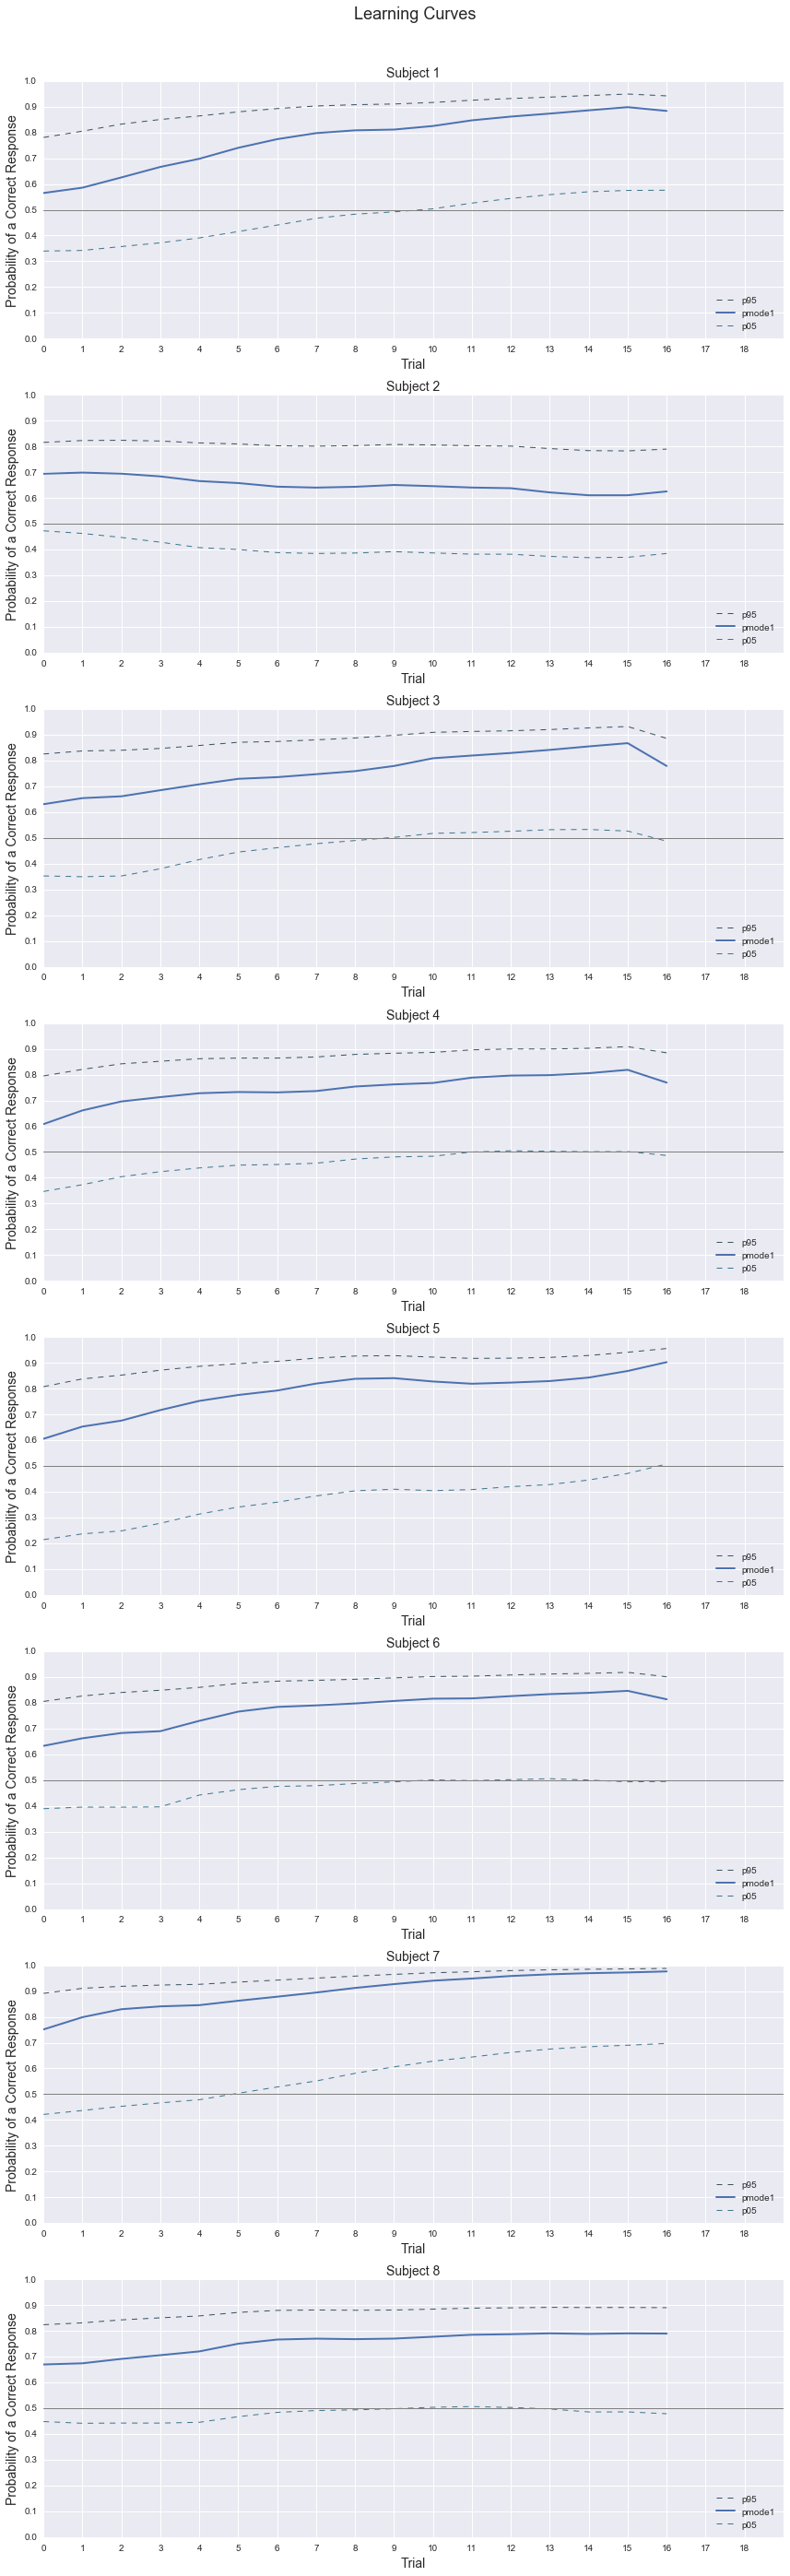

In [121]:
fig, ax = plt.subplots(len(em_average), figsize=(12,38))
for i in range(len(em_average)):
    t = range(0, len(em_average[i]['p05'])-1)
    ax[i].plot(t, em_average[i]['p95'][1:], color=sns.color_palette("GnBu_d")[0], ls='dashed', lw='1')
    ax[i].plot(t, em_average[i]['pmode1'][1:], lw="2")
    ax[i].plot(t, em_average[i]['p05'][1:], color=sns.color_palette("GnBu_d")[1], ls='dashed', lw='1')
    if len(em_average[i][pd.notnull(em_average[i]['cback'])]) == 0:
        cback = "N/A" 
    else:
        cback = int(em_average[i][pd.notnull(em_average[i]['cback'])]['cback'].values[0])
#     ax[i].set_title('Subject %s with learning trial = %s' % (i+1, cback), fontsize=14)
    ax[i].set_title('Subject %s' % (i+1), fontsize=14)
    ax[i].set_xlabel('Trial', fontsize=14)
    ax[i].set_ylabel('Probability of a Correct Response', fontsize=14)
    ax[i].set_ylim(0, 1)
    ax[i].set_yticks(np.arange(0, 1.1, 0.1))
    ax[i].set_xlim(0, len(em_average[i])+1)
    ax[i].set_xticks(np.arange(0, len(em_average[i])+1, 1))
    ax[i].axhline(y=0.5, color="gray", lw="1")
    fig.suptitle('Learning Curves', y=1.02, x=0.525, fontsize=18)
    plt.tight_layout()
    handles, labels = ax[i].get_legend_handles_labels()
    ax[i].legend(handles, labels, loc=4)

In [ ]:
fig, ax = plt.subplots(len(em_list), figsize=(15,28))
for i in range(len(em_list)):
    t = range(0, len(em_list[i]['p05'])-1)
    ax[i].plot(t, em_list[i]['p95'][1:], color=sns.color_palette("GnBu_d")[0], ls='dashed', lw='1')
    ax[i].plot(t, em_list[i]['pmode1'][1:], lw="2")
    ax[i].plot(t, em_list[i]['p05'][1:], color=sns.color_palette("GnBu_d")[1], ls='dashed', lw='1')
    if len(em_list[i][pd.notnull(em_list[i]['cback'])]) == 0:
        cback = "N/A" 
    else:
        cback = int(em_list[i][pd.notnull(em_list[i]['cback'])]['cback'].values[0])
    ax[i].set_title('Subject %s with learning trial = %s' % (i+1, cback), fontsize=14)
    ax[i].set_xlabel('Trial', fontsize=14)
    ax[i].set_ylabel('Probability of a Correct Response', fontsize=14)
    ax[i].set_ylim(0, 1)
    ax[i].set_xlim(0, 250)
    ax[i].axhline(y=0.5, color="gray", lw="1")
    fig.suptitle('Learning Curves', y=1.02, x=0.515, fontsize=18)
    plt.tight_layout()
    handles, labels = ax[i].get_legend_handles_labels()
    ax[i].legend(handles, labels, loc=4)

### The Final Feature Matrix

In [ ]:
# Remove Durations for now because NaN in Duration should not be 0 unless it is filled with something more meaningful

In [ ]:
# Features to add: Exploration Time
matrix = pd.concat(fm_list, axis=0, ignore_index=False)
matrix

## Machine Learning

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_predict

### All Subjects or k Subjects

In [ ]:
y

In [ ]:
k = 0
if not k:
    X = matrix[matrix.columns[2:]]
    y = matrix[matrix.columns[0:1]]
else:
    k = len(fm_list) - 1
    X = fm_list[k][fm_list[k].columns[2:]]
    y = fm_list[k][fm_list[k].columns[0:1]] 
    
# https://stats.stackexchange.com/questions/249892/wildly-different-r2-between-statsmodels-linear-regression-and-sklearn-linear/249897
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

### Smoothed Sliding Window

In [ ]:
len(y)

In [ ]:
k = 0
if not k:
    X = matrix[matrix.columns[2:]]
    y = matrix[matrix.columns[1:2]]
else:
    k = len(fm_list) - 1
    X = fm_list[k][fm_list[k].columns[2:]]
    y = fm_list[k][fm_list[k].columns[1:2]] 
    
# https://stats.stackexchange.com/questions/249892/wildly-different-r2-between-statsmodels-linear-regression-and-sklearn-linear/249897
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

### Scikit Learn's Linear Regression (With Intercept)

In [ ]:
lr.score?

In [ ]:
lr = LinearRegression(fit_intercept=True)
print str(lr) + "\n"
lr.fit(X_train, y_train)
print "Linear Regression Score: %f" % (lr.score(X_test, y_test))
print "Linear Regression Coefficients: %s" % (lr.coef_)

In [ ]:
# compare in
lr = LinearRegression()
# cross_val_predict returns an array of the same size as `y` where each entry
# is a prediction obtained by cross validation:
predicted = cross_val_predict(lr, X, y, cv=359)
fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(y, predicted)
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

### StatsModel's Linear Regression (With Intercept)

In [ ]:
model = sm.OLS(y_test, X_test)
results = model.fit()
print(results.summary())

In [ ]:
mean = []
mean.append(('FixCat 01 Count', results.params[3]))
mean.append(('FixCat 01 Duration', results.params[4]))
mean.append(('FixCat 02 Count', results.params[5]))
mean.append(('FixCat 02 Duration', results.params[6]))
mean_df = pd.DataFrame(mean, columns=['Feature Type', 'Coefficient Value'])

In [ ]:
results_list = []
d = []
for i in fm_list:
    X = i[i.columns[2:]]
    y = i[i.columns[1:2]]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
    model = sm.OLS(y_test, X_test)
    results = model.fit()
    #print(results.params)
    results_list.append(results.params)
for i in results_list:
    d.append(('FixCat 01 Count', i[3]))
    d.append(('FixCat 01 Duration', i[4]))
    d.append(('FixCat 02 Count', i[5]))
    d.append(('FixCat 02 Duration', i[6]))
d_df = pd.DataFrame(d, columns=['Feature Type', 'Coefficient Value'])

flatui = ["yellow", "yellow", 'yellow', "yellow"]
sns.color_palette(flatui)
fig = plt.figure(figsize=(20, 8))
sns.stripplot(x="Feature Type", y="Coefficient Value", data=d_df, size=12, marker='o', split=True,linewidth=2,edgecolor="gray")
sns.stripplot(x="Feature Type", y="Coefficient Value", data=mean_df, size=15, palette=sns.color_palette(flatui), split=True,linewidth=2,edgecolor="gray", marker='*')

In [ ]:
# https://stats.stackexchange.com/questions/146804/difference-between-statsmodel-ols-and-scikit-linear-regression
predictions = results.predict(X_test)

### SVM or SVR for Regression

In [ ]:
from sklearn.svm import SVR
svr = SVR(kernel='linear')

In [ ]:
svr.fit(X_train, y_train)

In [ ]:
svr.score(X_test, y_test)

In [ ]:
svr.coef_

## Cross Validation